# Cloud-radiative impact on ENSO variability

This notebook reproduces Figure 4.

Data: 
1. MPI-ESM-LR from Raedel et al., 2016, Nature Geoscience, Amplification of El Niño by cloud longwave
coupling to atmospheric circulation, doi: 10.1038/NGEO2630
2. CESM1.2 from Middlemas et al., 2019, J. Climate, Cloud Radiative Feedbacks and El Niño–Southern Oscillation, doi: 10.1175/JCLI-D-18-0842.1

## Load libraries

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib
import scipy; print('scipy:     ', scipy.__version__); del scipy

xarrary:    0.15.1
numpy:      1.18.1
matplotlib: 3.2.1
scipy:      1.4.1


## Load monthly-mean SST averaged over Nino3.4 region, deseasonalize and detrend

In [3]:
def load_data(fname, vname, tstart=None, tend=None):
    aux = xr.load_dataset(fname)[vname].values.squeeze()
    # if tstart and/or tend were handed over, then restrict time series accordingly;
    # otherwise use full time series
    if tstart is None: tstart=0
    if tend is None: tend = np.size(aux)
    data = aux[tstart:tend]
    # deseasonalize
    clim = np.zeros(12)+np.nan # monthly climatology
    ntim = np.size(data)       # number of months in data
    for m in range(0, 12):
        clim[m] = np.mean(data[m:ntim:12])
    des = np.zeros(ntim) + np.nan
    for m in range(0,12):
        des[m:ntim:12] = data[m:ntim:12] - clim[m]
    # detrend
    import scipy.stats as st
    time = np.arange(0, des.size)
    m, b, _, _, _ = st.linregress(time, des)
    out = des - (b + m*time)    
    return out # return deseasonlized and detrended data

MPI-ESM-LR:

In [4]:
mpi_free = load_data('../../data/enso/piControl_r1i1p1-LR_echam6_BOT_mm_1850-2849.tsurf_temp2.nino34-fldmean.nc', 'tsurf')

In [5]:
mpi_lock = load_data('../../data/enso/BOT_fixvar_random_1900-2100.tsurf_temp2.nino34-fldmean.nc', 'tsurf')

CESM1.2:

In [6]:
cam_free = load_data('../../data/enso/coup.ctrl_enso_nino34_regseries.nc', 'series', tstart=12, tend=21600)

In [7]:
cam_lock = load_data('../../data/enso/coup.cldlck_enso_nino34_regseries.nc', 'series', tstart=12, tend=4428)

### Compute power spectrum

We use Welch's method implemented in scipy, see https://github.com/aikovoigt/enso-powerspectrum for more information.

In [8]:
nyears=100 # use 100-year chunks of time series
overlap=75 # overlap between chunks in years
from scipy import signal

def compute_powerspectrum(data, nyears, overlap):
    
    # call Welch's method
    frq, psp = signal.spectral.welch(data, nperseg=nyears*12, noverlap=overlap*12)
    
    # make sure that area under power spectrum is same as 
    # variance of time series (this does not seem to be guaranteed by Welch's method)
    dfrq = frq[2]-frq[1] * np.ones(frq.size) # width of the frequency bands
    dfrq[0]  = 0.5 * (frq[2]-frq[1])  # first and last frquency band have half the width
    dfrq[-1] = 0.5 * (frq[2]-frq[1])
    psp = psp * np.var(data) / np.sum(psp*dfrq)
    
    return frq, psp

cam_free_frq, cam_free_psp = compute_powerspectrum(cam_free, nyears, overlap)
cam_lock_frq, cam_lock_psp = compute_powerspectrum(cam_lock, nyears, overlap)
mpi_free_frq, mpi_free_psp = compute_powerspectrum(mpi_free, nyears, overlap)
mpi_lock_frq, mpi_lock_psp = compute_powerspectrum(mpi_lock, nyears, overlap)

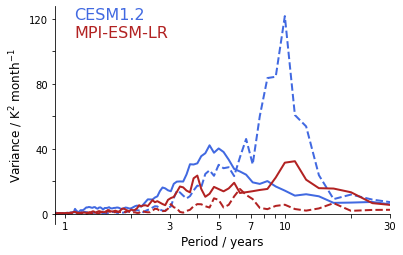

In [9]:
plt.figure(figsize=(6,4))

plt.semilogx(1/(12*cam_free_frq[1:]), cam_free_psp[1:], color='royalblue', linestyle='-' , linewidth=2)
plt.semilogx(1/(12*cam_lock_frq[1:]), cam_lock_psp[1:], color='royalblue', linestyle='--', linewidth=2)
plt.semilogx(1/(12*mpi_free_frq[1:]), mpi_free_psp[1:], color='firebrick', linestyle='-' , linewidth=2)
plt.semilogx(1/(12*mpi_lock_frq[1:]), mpi_lock_psp[1:], color='firebrick', linestyle='--', linewidth=2)

# adjust spines
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0))

plt.text(1.1, 120, 'CESM1.2', color='royalblue', size=16)
plt.text(1.1, 109, 'MPI-ESM-LR', color='firebrick', size=16)

plt.xlabel('Period / years', size=12); plt.ylabel(r'Variance / K$^{2}$ month$^{-1}$', size=12);

plt.xlim(0.9,30);
plt.xticks([1,2,3,4,5,6,7,8,9,10,20,30],['1','','3','','5','','7','','','10','','30'], size=10);
plt.yticks([0,20,40,60,80,100,120],['0','','40','','80','','120'], size=10);

plt.savefig('./figure-4.pdf')